# Week 7 - AI Lab

Author: Khushee Kapoor

Registration Number: 200968052

Problem Formulation: 

- State: The state of the system can be defined as the user's historical movie watching behavior, preferences, and any other relevant information such as age, gender, etc.

- Action: The action space consists of the recommended movies that the user can choose to watch.

- Reward: The reward function can be designed to optimize the user's satisfaction with the recommended movies. For example, the reward function can be based on the user's rating of the recommended movie, where a higher rating results in a higher reward. Alternatively, the reward function can be designed to maximize the user's engagement or diversity of the recommended movies.

- Environment: The environment consists of the movie recommendation system that takes the user's state and action as input and generates a recommendation as output.

- Policy: The policy defines the movie recommendation algorithm used to suggest the next movie for the user. The goal is to optimize the policy to maximize the cumulative reward over time.

The objective of the reinforcement learning algorithm in this context is to learn the optimal policy that recommends movies to the user, taking into account the user's preferences and historical behavior. The algorithm should aim to maximize the user's satisfaction or engagement with the recommended movies over time.

First, we set up tensorflow agents in the jupyter environment.

In [ ]:
# importing libraries and setting up tensorflow agents
import tensorflow as tf
!pip install tf_agents
import tf_agents
from tf_agents.bandits.environments import movielens_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.bandits.environments import environment_utilities
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.networks import q_network
from tf_agents.bandits.agents import neural_epsilon_greedy_agent as eps_greedy_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import random_tf_policy
import functools
import os
import numpy as np
from matplotlib import pyplot as plt

Next, we import the data from kaggle. We are using the MovieLens 100K data, on which the MoviePyEnvironment is based.

In [ ]:
# importing the data
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download prajitdatta/movielens-100k-dataset
!unzip /content/movielens-100k-dataset.zip

Next, we set the values of the common hyperparameters between all the three concextual agents. These include:
- Batch Size: number of observations generated per call
- Training Loops: we set to 500 instead of given 20000 to avoid crashing the notebook
- Rank K: to use in matrix factorization
- Number of Actions: that the model will output
- Data Path: to access the data
- Root Diretory: to store the checkpoints

In [3]:
# initializing the hyperparameters
BATCH_SIZE = 8
TRAINING_LOOPS = 500
STEPS_PER_LOOP = 2
RANK_K = 20
NUM_ACTIONS = 20

data_path = '/content/ml-100k/u.data'
root_dir = '/content/checkpoints'

Next, we set up the MovieLensPyEnvironment usign the above hyperparameters and wrap it in a TensorFlow environment.

In [4]:
# setting up the MovieLensPyEnvironment
env = movielens_py_environment.MovieLensPyEnvironment(
        data_path,
        RANK_K,
        BATCH_SIZE,
        num_movies=NUM_ACTIONS,
        csv_delimiter='\t')
environment = tf_py_environment.TFPyEnvironment(env)

Next, we declare two partial functions that use the Movielens environment to compute the optimal reward and optimal action for the given state.

- optimal_reward_fn: This is a partial function that computes the optimal reward for a given state using the Movielens environment. The function is created using the functools.partial method, which is a way to create a new function with a fixed set of arguments based on an existing function. In this case, the compute_optimal_reward_with_movielens_environment function is used as the base function, and the environment argument is passed in as a fixed argument. This partial function can be used to calculate the optimal reward for any state in the Movielens environment.

- optimal_action_fn: This is a partial function that computes the optimal action for a given state using the Movielens environment. Like optimal_reward_fn, the function is created using the functools.partial method, with the compute_optimal_action_with_movielens_environment function as the base function and the environment argument passed in as a fixed argument. This partial function can be used to calculate the optimal action (i.e., recommended movie) for any state in the Movielens environment.

These two partial functions are useful for evaluating the performance of a recommendation model trained using Reinforcement Learning. By comparing the rewards and actions produced by the model with the optimal values computed by these functions, we can determine how well the model is performing and whether it is learning to make good recommendations.

In [5]:
# partial function to evaluate reward function with optimal reward
optimal_reward_fn = functools.partial(
      environment_utilities.compute_optimal_reward_with_movielens_environment,
      environment=environment)

# partial function to evaluate action function with optimal action
optimal_action_fn = functools.partial(
      environment_utilities.compute_optimal_action_with_movielens_environment,
      environment=environment)

Next, we create an instance of the LinearUCBAgent class, which implements the LinUCB algorithm for contextual bandit problems. The hyperparameters used in this instance are:

- time_step_spec: This specifies the format of the input data that the agent receives from the environment at each time step. It includes the observation, reward, and discount, among other things.

- action_spec: This specifies the format of the actions that the agent can choose from. In this case, the agent can select one of the movies to recommend from the set of available actions.

- tikhonov_weight: This is a regularization hyperparameter that controls the amount of weight given to the L2 regularization term in the linear regression used by the LinUCB algorithm. It is used to prevent overfitting of the linear model to the data. In this case, the Tikhonov weight is set to 0.001.

- alpha: This is the exploration hyperparameter that we discussed earlier. It controls the tradeoff between exploration and exploitation in the LinUCB algorithm. In this case, the alpha value is set to the AGENT_ALPHA hyperparameter. This is a hyperparameter that determines the strength of the agent's exploration strategy. It controls the amount of weight given to the uncertainty term in the exploration-exploitation tradeoff of the LinUCB algorithm. In this case, the alpha value is set to 10.0, which means that the agent is relatively more exploratory than exploitative. Higher values of alpha result in more exploration, which can be useful when the agent is first learning about the environment, but may be less effective as the agent becomes more experienced.

- dtype: This specifies the data type of the variables used in the linear regression. In this case, tf.float32 is used.

- accepts_per_arm_features: This specifies whether the agent expects to receive per-arm features as input. In this case, it is set to False, meaning that the agent does not use per-arm features. Per-arm features are additional information that can be used to describe each of the available actions (movies) and can be useful for improving the quality of the recommendations.

In [6]:
# creating the LinUCB agent
AGENT_ALPHA = 10.0
linucb = lin_ucb_agent.LinearUCBAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        tikhonov_weight=0.001,
        alpha=AGENT_ALPHA,
        dtype=tf.float32,
        accepts_per_arm_features=False)

Next, we create an instance of the LinearThompsonSamplingAgent class, which implements the linear Thompson sampling algorithm for contextual bandit problems. This algorithm is similar to the LinUCB algorithm but uses a Bayesian approach to sample from the posterior distribution over the model parameters.

- time_step_spec: This parameter specifies the format of the input data that the agent receives from the environment at each time step. It includes the observation, reward, and discount, among other things.

- action_spec: This parameter specifies the format of the actions that the agent can choose from. In this case, the agent can select one of the movies to recommend from the set of available actions.

- dtype: This parameter specifies the data type of the variables used in the linear regression. In this case, tf.float32 is used.

- accepts_per_arm_features: This parameter specifies whether the agent expects to receive per-arm features as input. In this case, it is set to False, meaning that the agent does not use per-arm features. Per-arm features are additional information that can be used to describe each of the available actions (movies) and can be useful for improving the quality of the recommendations.

In [7]:
# creating the LinTS agent
lints = lin_ts_agent.LinearThompsonSamplingAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        dtype=tf.float32,
        accepts_per_arm_features=False)

Now, we initialize the following hyperparameters: 

- EPSILON: This is the probability of the agent choosing a random action instead of the greedy action (the action with the highest estimated reward). It controls the level of exploration versus exploitation in the agent's decision-making process.

- LAYERS: This is a tuple that specifies the number of hidden layers and the number of units in each layer of the Q-network used by the agent to estimate the rewards of different actions.

- LR: This is the learning rate used by the optimizer to update the Q-network parameters during training.

We use the above for the following:

Network: This is an instance of the QNetwork class, which defines the architecture of the Q-network used by the agent to estimate the rewards of different actions based on the observed states.

NeuralEpsilonGreedyAgent: This is an instance of the NeuralEpsilonGreedyAgent class, which implements the epsilon-greedy algorithm using a neural network as the Q-function approximator.
- time_step_spec: This parameter specifies the format of the input data that the agent receives from the environment at each time step. It includes the observation, reward, and discount, among other things.

- action_spec: This parameter specifies the format of the actions that the agent can choose from. In this case, the agent can select one of the movies to recommend from the set of available actions.

- reward_network: This parameter specifies the Q-network used by the agent to estimate the rewards of different actions based on the observed states.

- optimizer: This parameter specifies the optimizer used to update the Q-network parameters during training. In this case, the Adam optimizer is used with a learning rate of LR.

- emit_policy_info: This parameter specifies what policy information should be included in the data emitted by the agent during training. In this case, it includes the mean of the predicted rewards.

- info_fields_to_inherit_from_greedy: This parameter specifies what policy information should be inherited from the greedy policy. In this case, it includes the mean of the predicted rewards.





In [8]:
# creating the NeurEpsilon Greedy Agent
EPSILON = 0.05
LAYERS = (50, 50, 50)
LR = 0.005

network = q_network.QNetwork(
          input_tensor_spec=environment.time_step_spec().observation,
          action_spec=environment.action_spec(),
          fc_layer_params=LAYERS)

neureps = eps_greedy_agent.NeuralEpsilonGreedyAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        reward_network=network,
        optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
        epsilon=EPSILON,
        emit_policy_info='predicted_rewards_mean',
        info_fields_to_inherit_from_greedy=['predicted_rewards_mean'])

Next, we define the following metrics:
- RegretMetric: This is a metric that measures the difference between the total reward obtained by the bandit agent and the total reward that would have been obtained by always choosing the optimal action at each time step. It computes the cumulative regret over the course of the training process.
- SuboptimalArmsMetric: This is a metric that measures the proportion of time steps where the agent chooses a suboptimal action (an action other than the optimal action). It is a useful metric for evaluating the level of exploration versus exploitation in the agent's decision-making process.

In [9]:
# defining the regret metric
regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)
suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(optimal_action_fn)

We then define a function to train the agent.

In [10]:
def train(agent):

  if agent == 'LinUCB':
    agent = linucb
  elif agent == 'LinTS':
    agent = lints
  elif agent == 'NeurEps':
    agent = neureps


  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=BATCH_SIZE,
    max_length=STEPS_PER_LOOP)

  observers = [replay_buffer.add_batch, regret_metric]

  driver = dynamic_step_driver.DynamicStepDriver(
      env=environment,
      policy=agent.collect_policy,
      num_steps=STEPS_PER_LOOP * BATCH_SIZE,
      observers=observers)

  regret_values = []

  for _ in range(TRAINING_LOOPS):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    regret_values.append(regret_metric.result())

  return regret_values, agent

We first train the LinUCB agent and plot the regret values.

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Text(0, 0.5, 'Average Regret')

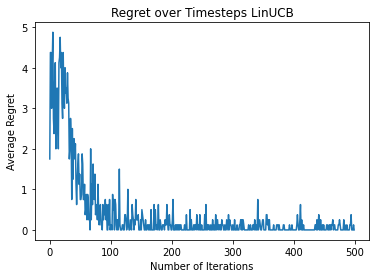

In [11]:
# plotting the regret values of the LinUCB agent
regret_values_linucb, linucb_agent = train('LinUCB')
plt.plot(regret_values_linucb)
plt.title('Regret over Timesteps LinUCB')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')

As we can see, the regret decreases over time. We also find the cummulative regret using the sum function.

In [12]:
# summation of regret values
sum(regret_values_linucb)

<tf.Tensor: shape=(), dtype=float32, numpy=215.5>

As we can see, the cummulative regret is 215.5

Next, we train the LinTS agent and plot the regret values.

Text(0, 0.5, 'Average Regret')

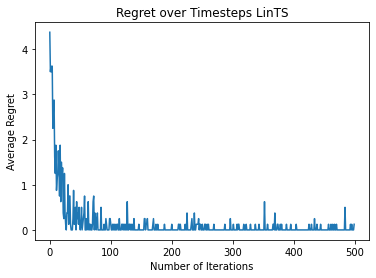

In [13]:
# plotting the regret values of the LinTS agent
regret_values_lints, lints_agent = train('LinTS')
plt.plot(regret_values_lints)
plt.title('Regret over Timesteps LinTS')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')

As we can see, the regret decreases over time. We also find the cummualitve regret using the sum function.

In [14]:
# summation of regret values
sum(regret_values_lints)

<tf.Tensor: shape=(), dtype=float32, numpy=76.5>

As we can see, the cummulative regret is 76.5

Next, we train the LinTS agent and plot the regret values.

Text(0, 0.5, 'Average Regret')

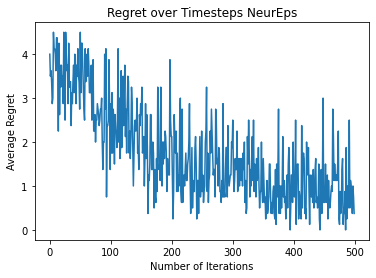

In [15]:
# plotting the regret values if NeurEpsilon Greedy agent
regret_values_neureps, neureps_agent = train('NeurEps')
plt.plot(regret_values_neureps)
plt.title('Regret over Timesteps NeurEps')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')

As we can see, the regret decreases over time. We also find the cummualitve regret using the sum function.

In [16]:
# summation of regret values
sum(regret_values_neureps)

<tf.Tensor: shape=(), dtype=float32, numpy=888.875>

As we can see, the cummulative regret is 888.875.

From the values of the cummulative regret, we can infer that the **best agent in LinTS as it has the least cummulative regret**.

Now, we write a Recommendation policy, which when given a new observation request (i.e. a user vector), the policy will produce actions, which are the recommended movies.

First, it creates a TimeStep object that represents the current time step in the RL environment, with the given observation and initial values for the step type, reward, and discount.

Then, it uses the agent's policy to select an action for the given time step. The action method of the policy returns an ActionStep object that contains the recommended action.

Finally, the function returns the recommended action as a numpy array. The [0] index is used to extract the scalar value from the one-element numpy array.

In [17]:
# recommendation policy
def recommend_movies(agent, observation):
    time_step = tf_agents.trajectories.time_step.TimeStep(
        step_type=tf.constant([[2]], dtype=tf.int32),
        reward=tf.constant([[0.0]], dtype=tf.float32),
        discount=tf.constant([[1.0]], dtype=tf.float32),
        observation=observation)
    
    action_step = agent.policy.action(time_step)
    return action_step.action.numpy()[0]

To test out the policy, we input a random observation vector and get the recommended movie id in return. We use the LinTS agent to check it out, as the it was best performer as per our analysis.

In [18]:
# testing out the policy
observation = np.array([1, 25, 35, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1])
observation = np.expand_dims(observation, axis=0)
recommend_movies(lints_agent, observation=observation)

13

As we can see, for the given vector, we get the movie id recommendation 13.